#   Risk Scoring System
## Combines: Isolation Forest + One-Class SVM + LSTM Autoencoder

**Task 2B: Risk Scoring Logic**

This notebook:
1. Loads all three trained models
2. Scores each window with all models
3. Combines scores with clinical logic
4. Generates risk levels and alerts

Uploading Files

In [ ]:
from google.colab import files
uploaded = files.upload()

# Uploaded these files:
# 1. iso_forest.pkl (from classical ML notebook)
# 2. ocsvm.pkl (from classical ML notebook)
# 3. lstm_autoencoder.keras (from deep learning notebook)
# 4. window_dataset.csv ( windowed features)

Saving lstm_autoencoder.keras to lstm_autoencoder.keras
Saving ocsvm.pkl to ocsvm.pkl
Saving iso_forest.pkl to iso_forest.pkl


 2: Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


##  3: Loading All Models

In [ ]:

scaler, iso = joblib.load("/content/iso_forest.pkl")
ocsvm = joblib.load("/content/ocsvm.pkl")

lstm_model = load_model("/content/lstm_autoencoder.keras")

print(" All models loaded successfully")
print(f"   - Isolation Forest: {iso.n_estimators} trees")
print(f"   - One-Class SVM: kernel={ocsvm.kernel}")
print(f"   - LSTM Autoencoder: loaded")

 All models loaded successfully
   - Isolation Forest: 400 trees
   - One-Class SVM: kernel=rbf
   - LSTM Autoencoder: loaded


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving window_dataset.csv to window_dataset.csv




```
# This is formatted as code
```

##  4: Loading and Preparing Data

In [ ]:
# Load windowed dataset
df = pd.read_csv("/content/window_dataset.csv")

# Define feature columns (same as training)
FEATURE_COLS = [
    'hr_mean','spo2_mean','sbp_mean','dbp_mean',
    'hr_std','spo2_std','sbp_std','dbp_std',
    'hr_slope','spo2_slope','sbp_slope','dbp_slope',
    'hr_min','hr_max','spo2_min','spo2_max',
    'hr_spo2_corr','pp_mean','pp_std',
    'motion_mean','motion_max'
]

print(f" Data loaded: {len(df)} windows")
print(f"   Patients: {df['patient_id'].nunique()}")
print(f"   Features: {len(FEATURE_COLS)}")

 Data loaded: 20700 windows
   Patients: 50
   Features: 21


##  5: Score Windows with Classical Models

In [ ]:
# Extract features
X = df[FEATURE_COLS].values

# Scale features (using prefitted scaler)
X_scaled = scaler.transform(X)

# Get anomaly scores (higher = more anomalous)
iso_scores = -iso.decision_function(X_scaled)
svm_scores = -ocsvm.decision_function(X_scaled)

# Add to dataframe
df['iso_score'] = iso_scores
df['svm_score'] = svm_scores

print("Classical ML scoring complete")
print(f"   ISO scores: min={iso_scores.min():.3f}, max={iso_scores.max():.3f}")
print(f"   SVM scores: min={svm_scores.min():.3f}, max={svm_scores.max():.3f}")

Classical ML scoring complete
   ISO scores: min=-0.139, max=0.150
   SVM scores: min=-41.295, max=32.613


## 6: Score Windows with LSTM

LSTM requires sequences of 10 windows, so we need to:
1. Create sequences for each patient
2. Get reconstruction errors
3. Map back to window indices

In [19]:
def create_sequences_for_patient(patient_df, seq_len=10):
    """
    Create sequences from patient's windows
    Returns: sequences array and corresponding window indices
    """
    features = patient_df[FEATURE_COLS].values
    sequences = []
    window_indices = []

    for i in range(len(features) - seq_len + 1):
        sequences.append(features[i:i+seq_len])
        # The sequence represents window i+seq_len-1 (the last window in the sequence)
        window_indices.append(i + seq_len - 1)

    return np.array(sequences), window_indices

# Initialize LSTM scores array (NaN for windows without sequences)
lstm_scores = np.full(len(df), np.nan)

# Process each patient separately
for patient_id in df['patient_id'].unique():
    # Get patient data
    patient_mask = df['patient_id'] == patient_id
    patient_df = df[patient_mask].reset_index(drop=True)
    patient_indices = df[patient_mask].index.values

    # Create sequences
    if len(patient_df) >= 10:
        sequences, seq_window_indices = create_sequences_for_patient(patient_df, seq_len=10)

        # Get reconstruction errors
        reconstructed = lstm_model.predict(sequences, verbose=0)
        recon_errors = np.mean((sequences - reconstructed)**2, axis=(1, 2))

        # Map reconstruction errors back to original dataframe indices
        for seq_idx, window_idx in enumerate(seq_window_indices):
            original_idx = patient_indices[window_idx]
            lstm_scores[original_idx] = recon_errors[seq_idx]

# Add to dataframe
df['lstm_score'] = lstm_scores

# Fill NaN values with median (for first 9 windows of each patient)
lstm_median = np.nanmedian(lstm_scores)
df['lstm_score'].fillna(lstm_median, inplace=True)

print(" LSTM scoring complete")
print(f"   LSTM scores: min={df['lstm_score'].min():.6f}, max={df['lstm_score'].max():.6f}")
print(f"   Windows scored: {(~np.isnan(lstm_scores)).sum()} / {len(df)}")

 LSTM scoring complete
   LSTM scores: min=16.451993, max=596.818245
   Windows scored: 20250 / 20700


## 7: Normalize Scores to [0, 1]

In [ ]:
def normalize_scores(scores):
    """
    Normalize scores to [0, 1] using min-max scaling
    Higher normalized score = more anomalous
    """
    min_score = scores.min()
    max_score = scores.max()
    return (scores - min_score) / (max_score - min_score + 1e-8)

# Normalize all scores
df['iso_norm'] = normalize_scores(df['iso_score'])
df['svm_norm'] = normalize_scores(df['svm_score'])
df['lstm_norm'] = normalize_scores(df['lstm_score'])

print("✅ Scores normalized to [0, 1]")
print(f"   ISO normalized: min={df['iso_norm'].min():.3f}, max={df['iso_norm'].max():.3f}")
print(f"   SVM normalized: min={df['svm_norm'].min():.3f}, max={df['svm_norm'].max():.3f}")
print(f"   LSTM normalized: min={df['lstm_norm'].min():.3f}, max={df['lstm_norm'].max():.3f}")

✅ Scores normalized to [0, 1]
   ISO normalized: min=0.000, max=1.000
   SVM normalized: min=0.000, max=1.000
   LSTM normalized: min=0.000, max=1.000


In [25]:
print("📊 BEFORE rescaling:")
print(f"HR mean: {df['hr_mean'].mean():.1f}")
print(f"SpO2 mean: {df['spo2_mean'].mean():.1f}")

# Rescale HR: shift mean from 105 → 78
hr_shift = 78 - df['hr_mean'].mean()
hr_cols = ['hr_mean', 'hr_min', 'hr_max']
for col in hr_cols:
    if col in df.columns:
        df[col] = df[col] + hr_shift

# Rescale SpO2: shift mean from 94 → 97.5
spo2_shift = 97.5 - df['spo2_mean'].mean()
spo2_cols = ['spo2_mean', 'spo2_min', 'spo2_max']
for col in spo2_cols:
    if col in df.columns:
        df[col] = df[col] + spo2_shift
        # Clip to valid range [80, 100]
        df[col] = df[col].clip(80, 100)

# Recalculate derived features if needed
if 'hr_spo2_corr' in df.columns:
    # Correlation won't change with shifting, so leave it
    pass

print("\n📊 AFTER rescaling:")
print(f"HR mean: {df['hr_mean'].mean():.1f}")
print(f"SpO2 mean: {df['spo2_mean'].mean():.1f}")
print(f"% HR > 120: {100*(df['hr_mean'] > 120).sum()/len(df):.1f}%")
print(f"% SpO2 < 92: {100*(df['spo2_mean'] < 92).sum()/len(df):.1f}%")

# IMPORTANT: Also need to rescale the raw features for model scoring
# Re-extract features for X after rescaling
X = df[FEATURE_COLS].values
X_scaled = scaler.transform(X)
# Then continue with scoring...

📊 BEFORE rescaling:
HR mean: 105.1
SpO2 mean: 94.1

📊 AFTER rescaling:
HR mean: 78.0
SpO2 mean: 97.0
% HR > 120: 2.8%
% SpO2 < 92: 10.7%


##  8: RISK SCORING FUNCTION

 ** Task 2B**. The function combines:
1. **Ensemble anomaly score** (weighted average of 3 models)
2. **Clinical severity multipliers** (SpO2 < 90, rapid HR increase, etc.)
3. **Temporal persistence** (sustained vs brief)
4. **Multi-vital coherence** (multiple vitals abnormal together)
5. **Motion artifact suppression** (reduce confidence during high motion)
6. **Model agreement confidence** (all models agree → high confidence)

In [26]:
def calculate_risk_score(row, history_df, window_idx, lookback=5):
    """
    Calculate comprehensive risk score for a single window

    Parameters:
    - row: Current window data (pandas Series)
    - history_df: DataFrame with recent history for persistence check
    - window_idx: Index of current window in history_df
    - lookback: Number of previous windows to check for persistence

    Returns:
    - risk_score: Final risk score (0-1+)
    - risk_level: 'NORMAL', 'WARNING', or 'CRITICAL'
    - confidence: Confidence in the alert (0-1)
    - reasoning: List of triggered conditions
    """

    reasoning = []

    # ========================================
    # 1. ENSEMBLE ANOMALY SCORE (weighted average)
    # ========================================
    # Weight LSTM higher (better temporal context)
    ensemble_score = (
        0.30 * row['iso_norm'] +
        0.30 * row['svm_norm'] +
        0.40 * row['lstm_norm']
    )

    # ========================================
    # 2. CLINICAL SEVERITY MULTIPLIERS
    # ========================================
    severity = 1.0

    # Critical SpO2 (oxygen desaturation)
    if row['spo2_min'] < 88:
        severity *= 3.0
        reasoning.append(f"CRITICAL SpO2: {row['spo2_min']:.1f}% < 88%")
    elif row['spo2_min'] < 92:
        severity *= 2.0
        reasoning.append(f"Low SpO2: {row['spo2_min']:.1f}% < 92%")
    elif row['spo2_mean'] < 94:
        severity *= 1.3
        reasoning.append(f"Borderline SpO2: {row['spo2_mean']:.1f}% < 94%")

    # Rapid Heart Rate increase (early warning)
    if row['hr_slope'] > 5:  # Rising > 5 bpm per 30-second window
        severity *= 1.5
        reasoning.append(f"Rapid HR increase: +{row['hr_slope']:.1f} bpm/window")
    elif row['hr_slope'] > 2:
        severity *= 1.2
        reasoning.append(f"Moderate HR increase: +{row['hr_slope']:.1f} bpm/window")

    # Tachycardia (high heart rate)
    if row['hr_mean'] > 140:
        severity *= 2.0
        reasoning.append(f"Severe tachycardia: HR={row['hr_mean']:.0f} > 140")
    elif row['hr_mean'] > 120:
        severity *= 1.5
        reasoning.append(f"Tachycardia: HR={row['hr_mean']:.0f} > 120")

    # Bradycardia (low heart rate)
    if row['hr_mean'] < 45:
        severity *= 2.0
        reasoning.append(f"Severe bradycardia: HR={row['hr_mean']:.0f} < 45")
    elif row['hr_mean'] < 55:
        severity *= 1.3
        reasoning.append(f"Bradycardia: HR={row['hr_mean']:.0f} < 55")

    # Multi-vital distress (combined HR + SpO2 problems)
    if row['hr_mean'] > 120 and row['spo2_mean'] < 92:
        severity *= 2.5
        reasoning.append(f"Multi-vital distress: HR={row['hr_mean']:.0f} + SpO2={row['spo2_mean']:.1f}%")

    # High variability (unstable vitals)
    if row['hr_std'] > 15:
        severity *= 1.3
        reasoning.append(f"High HR variability: std={row['hr_std']:.1f}")

    # Abnormal blood pressure (if available)
    if 'sbp_mean' in row.index:
        if row['sbp_mean'] > 180 or row['sbp_mean'] < 90:
            severity *= 1.5
            reasoning.append(f"Abnormal BP: SBP={row['sbp_mean']:.0f}")

    # ========================================
    # 3. TEMPORAL PERSISTENCE
    # ========================================
    persistence_score = 1.0

    if window_idx >= lookback:
        # Get last 'lookback' windows
        recent_windows = history_df.iloc[window_idx-lookback:window_idx]

        # Check how many recent windows have high ensemble scores
        recent_ensemble = (
            0.30 * recent_windows['iso_norm'] +
            0.30 * recent_windows['svm_norm'] +
            0.40 * recent_windows['lstm_norm']
        )

        persistent_anomalies = (recent_ensemble > 0.6).sum()

        if persistent_anomalies >= 4:  # 4 out of 5 windows
            persistence_score = 1.5
            reasoning.append(f"Sustained anomaly: {persistent_anomalies}/{lookback} windows")
        elif persistent_anomalies >= 3:
            persistence_score = 1.3
            reasoning.append(f"Recurring anomaly: {persistent_anomalies}/{lookback} windows")

    # ========================================
    # 4. MODEL AGREEMENT (Confidence)
    # ========================================
    # If all models agree, we're more confident
    model_scores = [row['iso_norm'], row['svm_norm'], row['lstm_norm']]

    # Standard deviation of normalized scores (low = high agreement)
    score_std = np.std(model_scores)

    if score_std < 0.1:  # Very high agreement
        model_confidence = 1.0
        reasoning.append("High model agreement")
    elif score_std < 0.2:  # Good agreement
        model_confidence = 0.9
    elif score_std < 0.3:  # Moderate agreement
        model_confidence = 0.7
    else:  # Models disagree
        model_confidence = 0.5
        reasoning.append("Low model agreement (uncertain)")

    # ========================================
    # 5. MOTION ARTIFACT SUPPRESSION
    # ========================================
    motion_confidence = 1.0

    # High motion reduces confidence (likely artifact)
    if row['motion_max'] > 0.8:  # Adjust threshold based on your motion scale
        motion_confidence = 0.4
        reasoning.append(f"High motion detected: {row['motion_max']:.2f} (likely artifact)")
    elif row['motion_max'] > 0.6:
        motion_confidence = 0.7
        reasoning.append(f"Moderate motion: {row['motion_max']:.2f}")

    # If SpO2 drop coincides with high motion, likely artifact
    if row['motion_max'] > 0.6 and row['spo2_slope'] < -2:
        motion_confidence *= 0.5
        reasoning.append("SpO2 drop during motion (possible artifact)")

    # ========================================
    # 6. FINAL RISK SCORE
    # ========================================
    base_risk = ensemble_score * severity * persistence_score
    overall_confidence = model_confidence * motion_confidence

    # Final risk score (weighted by confidence)
    risk_score = base_risk * overall_confidence

    # ========================================
    # 7. RISK LEVEL CLASSIFICATION
    # ========================================
    if risk_score > 1.5 and overall_confidence > 0.6:
        risk_level = 'CRITICAL'
    elif risk_score > 0.8 and overall_confidence > 0.5:
        risk_level = 'WARNING'
    else:
        risk_level = 'NORMAL'

    # ========================================
    # 8. ALERT SUPPRESSION LOGIC
    # ========================================
    # Suppress alert if:
    # - High motion AND no severe clinical signs
    # - Low confidence AND risk not extremely high

    if motion_confidence < 0.5 and severity < 2.0:
        risk_level = 'NORMAL'  # Likely artifact, suppress
        reasoning.append("ALERT SUPPRESSED: Motion artifact without severe vitals")

    if overall_confidence < 0.4 and risk_score < 2.0:
        risk_level = 'NORMAL'  # Too uncertain
        reasoning.append("ALERT SUPPRESSED: Low confidence")

    return {
        'risk_score': risk_score,
        'risk_level': risk_level,
        'confidence': overall_confidence,
        'ensemble_score': ensemble_score,
        'severity': severity,
        'persistence': persistence_score,
        'reasoning': reasoning
    }

print(" Risk scoring function defined")

 Risk scoring function defined


##  9: Apply Risk Scoring to All Windows

In [27]:
# Initialize result columns
df['risk_score'] = 0.0
df['risk_level'] = 'NORMAL'
df['confidence'] = 0.0
df['ensemble_score'] = 0.0
df['severity'] = 1.0
df['persistence'] = 1.0
df['reasoning'] = [[] for _ in range(len(df))]

# Process each patient separately (for temporal persistence)
for patient_id in df['patient_id'].unique():
    patient_mask = df['patient_id'] == patient_id
    patient_df = df[patient_mask].copy()
    patient_indices = df[patient_mask].index.values

    # Calculate risk for each window in this patient
    for i, (idx, row) in enumerate(patient_df.iterrows()):
        result = calculate_risk_score(row, patient_df, i, lookback=5)

        # Store results
        original_idx = patient_indices[i]
        df.at[original_idx, 'risk_score'] = result['risk_score']
        df.at[original_idx, 'risk_level'] = result['risk_level']
        df.at[original_idx, 'confidence'] = result['confidence']
        df.at[original_idx, 'ensemble_score'] = result['ensemble_score']
        df.at[original_idx, 'severity'] = result['severity']
        df.at[original_idx, 'persistence'] = result['persistence']
        df.at[original_idx, 'reasoning'] = result['reasoning']

print(" Risk scoring complete for all windows")
print(f"\nRisk Level Distribution:")
print(df['risk_level'].value_counts())
print(f"\nRisk Score Statistics:")
print(df['risk_score'].describe())

 Risk scoring complete for all windows

Risk Level Distribution:
risk_level
NORMAL      18205
WARNING      1892
CRITICAL      603
Name: count, dtype: int64

Risk Score Statistics:
count    20700.000000
mean         0.431253
std          0.676597
min          0.028626
25%          0.150789
50%          0.236920
75%          0.478153
max         17.141358
Name: risk_score, dtype: float64


##  10: Visualize Risk Scores

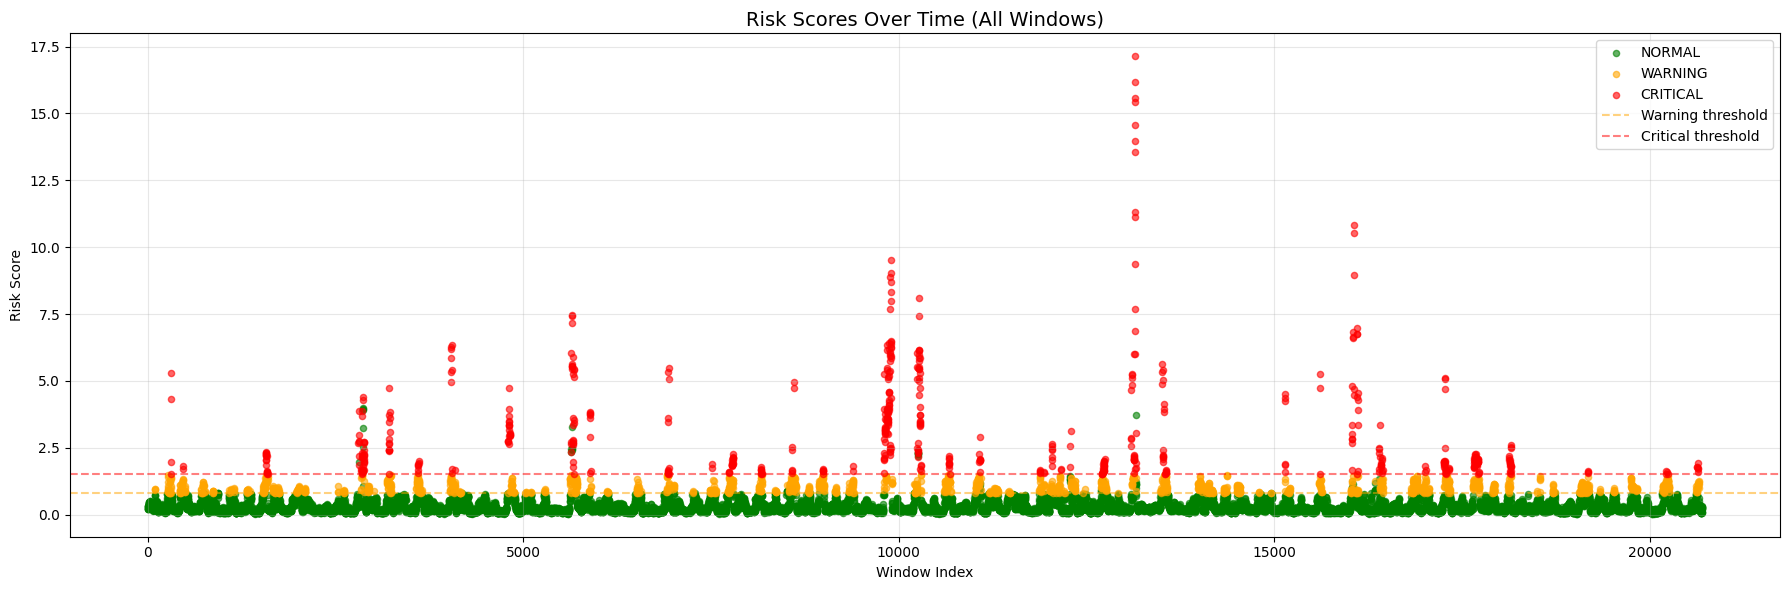

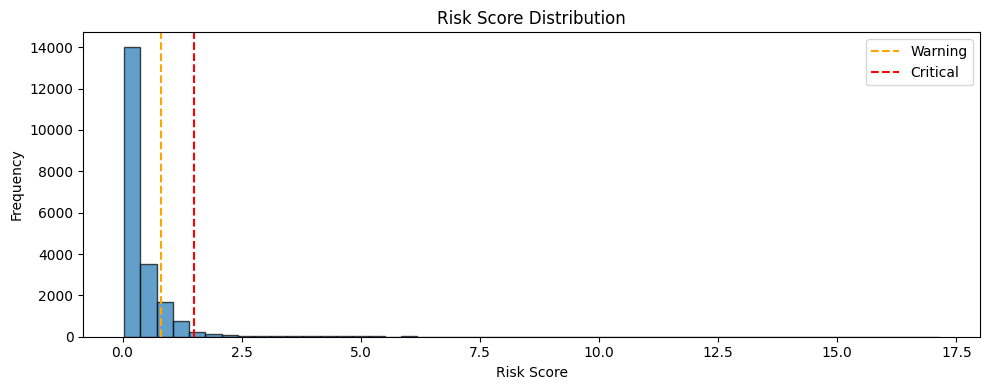

In [28]:
# Plot risk scores over time
plt.figure(figsize=(18, 6))

# Color-code by risk level
colors = {'NORMAL': 'green', 'WARNING': 'orange', 'CRITICAL': 'red'}
for level in ['NORMAL', 'WARNING', 'CRITICAL']:
    mask = df['risk_level'] == level
    plt.scatter(df[mask].index, df[mask]['risk_score'],
               c=colors[level], label=level, alpha=0.6, s=20)

# Threshold lines
plt.axhline(y=0.8, color='orange', linestyle='--', alpha=0.5, label='Warning threshold')
plt.axhline(y=1.5, color='red', linestyle='--', alpha=0.5, label='Critical threshold')

plt.title('Risk Scores Over Time (All Windows)', fontsize=14)
plt.xlabel('Window Index')
plt.ylabel('Risk Score')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Distribution of risk scores
plt.figure(figsize=(10, 4))
plt.hist(df['risk_score'], bins=50, alpha=0.7, edgecolor='black')
plt.axvline(0.8, color='orange', linestyle='--', label='Warning')
plt.axvline(1.5, color='red', linestyle='--', label='Critical')
plt.title('Risk Score Distribution')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

##  11: Analyze High-Risk Events

In [29]:
# Filter critical and warning events
alerts = df[df['risk_level'].isin(['WARNING', 'CRITICAL'])].copy()

print(f"\n{'='*80}")
print(f"HIGH-RISK EVENTS DETECTED")
print(f"{'='*80}")
print(f"Total alerts: {len(alerts)} / {len(df)} windows ({100*len(alerts)/len(df):.1f}%)")
print(f"  - Critical: {(df['risk_level']=='CRITICAL').sum()}")
print(f"  - Warning:  {(df['risk_level']=='WARNING').sum()}")

# Show top 10 highest risk events
print(f"\n{'='*80}")
print(f"TOP 10 HIGHEST RISK EVENTS")
print(f"{'='*80}")

top_risks = df.nlargest(10, 'risk_score')[[
    'patient_id', 'risk_score', 'risk_level', 'confidence',
    'hr_mean', 'spo2_mean', 'motion_max', 'ensemble_score'
]].copy()

for idx, row in top_risks.iterrows():
    print(f"\nWindow {idx}:")
    print(f"  Patient: {row['patient_id']}")
    print(f"  Risk Score: {row['risk_score']:.3f} ({row['risk_level']})")
    print(f"  Confidence: {row['confidence']:.2f}")
    print(f"  Vitals: HR={row['hr_mean']:.0f}, SpO2={row['spo2_mean']:.1f}%, Motion={row['motion_max']:.2f}")
    print(f"  Reasons: {', '.join(df.at[idx, 'reasoning'][:3])}...")  # Show first 3 reasons


HIGH-RISK EVENTS DETECTED
Total alerts: 2495 / 20700 windows (12.1%)
  - Critical: 603
  - Warning:  1892

TOP 10 HIGHEST RISK EVENTS

Window 13146:
  Patient: 32
  Risk Score: 17.141 (CRITICAL)
  Confidence: 1.00
  Vitals: HR=126, SpO2=87.4%, Motion=0.22
  Reasons: CRITICAL SpO2: 86.7% < 88%, Tachycardia: HR=126 > 120, Multi-vital distress: HR=126 + SpO2=87.4%...

Window 13151:
  Patient: 32
  Risk Score: 16.174 (CRITICAL)
  Confidence: 1.00
  Vitals: HR=124, SpO2=88.8%, Motion=0.17
  Reasons: CRITICAL SpO2: 87.5% < 88%, Tachycardia: HR=124 > 120, Multi-vital distress: HR=124 + SpO2=88.8%...

Window 13147:
  Patient: 32
  Risk Score: 15.566 (CRITICAL)
  Confidence: 1.00
  Vitals: HR=127, SpO2=87.6%, Motion=0.22
  Reasons: CRITICAL SpO2: 86.7% < 88%, Tachycardia: HR=127 > 120, Multi-vital distress: HR=127 + SpO2=87.6%...

Window 13148:
  Patient: 32
  Risk Score: 15.440 (CRITICAL)
  Confidence: 1.00
  Vitals: HR=127, SpO2=87.9%, Motion=0.22
  Reasons: CRITICAL SpO2: 86.7% < 88%, Tachy

##  12: Visualize Specific Patient with Alerts

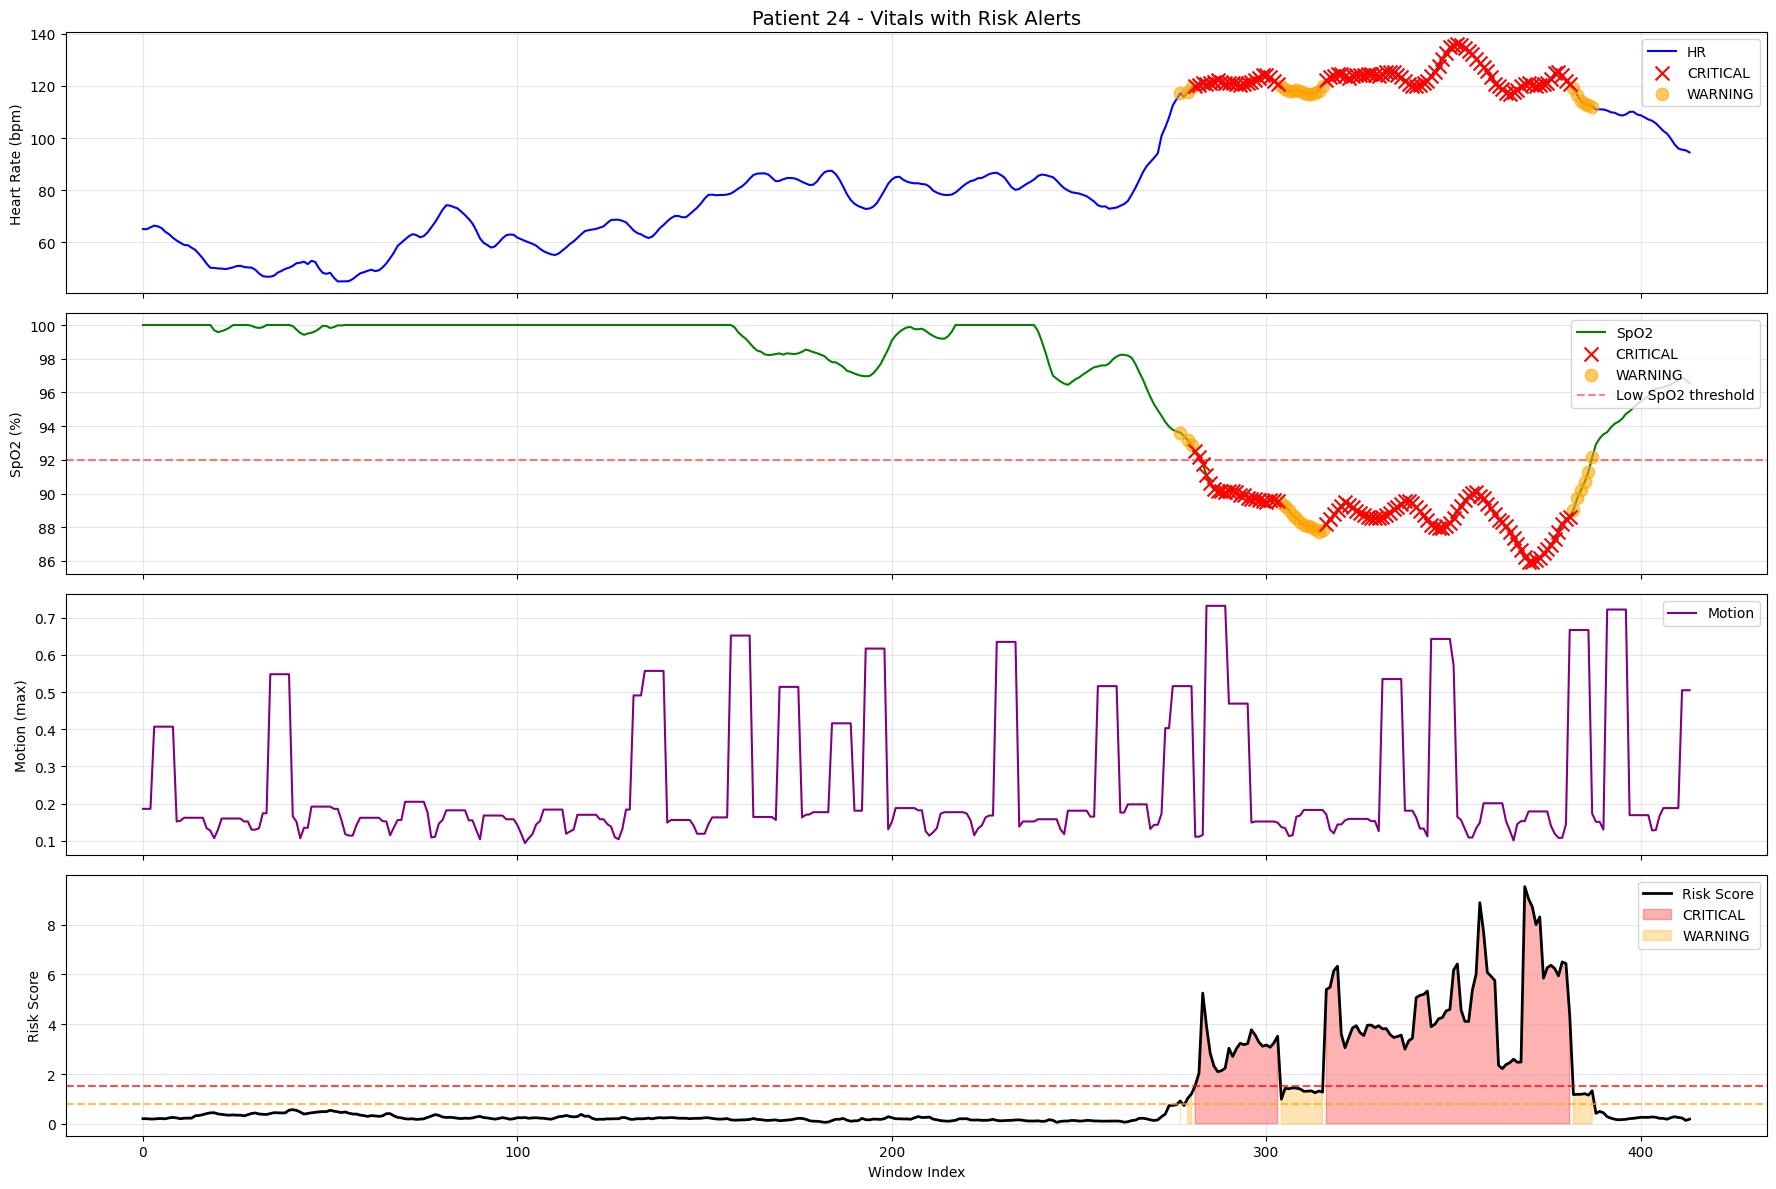

In [30]:
# Select a patient with alerts
patient_with_alerts = alerts['patient_id'].value_counts().index[0]
patient_data = df[df['patient_id'] == patient_with_alerts].copy()

fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharex=True)

x = np.arange(len(patient_data))

# Plot 1: Heart Rate with alerts
axes[0].plot(x, patient_data['hr_mean'], label='HR', color='blue', linewidth=1.5)
critical_mask = patient_data['risk_level'] == 'CRITICAL'
warning_mask = patient_data['risk_level'] == 'WARNING'
axes[0].scatter(x[critical_mask], patient_data['hr_mean'][critical_mask],
               c='red', s=100, marker='x', label='CRITICAL', zorder=5)
axes[0].scatter(x[warning_mask], patient_data['hr_mean'][warning_mask],
               c='orange', s=80, marker='o', alpha=0.6, label='WARNING', zorder=4)
axes[0].set_ylabel('Heart Rate (bpm)')
axes[0].set_title(f'Patient {patient_with_alerts} - Vitals with Risk Alerts', fontsize=14)
axes[0].legend(loc='upper right')
axes[0].grid(alpha=0.3)

# Plot 2: SpO2 with alerts
axes[1].plot(x, patient_data['spo2_mean'], label='SpO2', color='green', linewidth=1.5)
axes[1].scatter(x[critical_mask], patient_data['spo2_mean'][critical_mask],
               c='red', s=100, marker='x', label='CRITICAL', zorder=5)
axes[1].scatter(x[warning_mask], patient_data['spo2_mean'][warning_mask],
               c='orange', s=80, marker='o', alpha=0.6, label='WARNING', zorder=4)
axes[1].axhline(y=92, color='red', linestyle='--', alpha=0.5, label='Low SpO2 threshold')
axes[1].set_ylabel('SpO2 (%)')
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3)

# Plot 3: Motion
axes[2].plot(x, patient_data['motion_max'], label='Motion', color='purple', linewidth=1.5)
axes[2].set_ylabel('Motion (max)')
axes[2].legend(loc='upper right')
axes[2].grid(alpha=0.3)

# Plot 4: Risk Score
axes[3].plot(x, patient_data['risk_score'], label='Risk Score', color='black', linewidth=2)
axes[3].fill_between(x, 0, patient_data['risk_score'],
                     where=(patient_data['risk_level']=='CRITICAL'),
                     color='red', alpha=0.3, label='CRITICAL')
axes[3].fill_between(x, 0, patient_data['risk_score'],
                     where=(patient_data['risk_level']=='WARNING'),
                     color='orange', alpha=0.3, label='WARNING')
axes[3].axhline(y=0.8, color='orange', linestyle='--', alpha=0.7)
axes[3].axhline(y=1.5, color='red', linestyle='--', alpha=0.7)
axes[3].set_ylabel('Risk Score')
axes[3].set_xlabel('Window Index')
axes[3].legend(loc='upper right')
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

##  13: Save Results

In [32]:
# Save full results
df.to_csv('risk_scored_windows.csv', index=False)
print(" Saved: risk_scored_windows.csv")

# Save alerts only
alerts_df = df[df['risk_level'].isin(['WARNING', 'CRITICAL'])].copy()
alerts_df.to_csv('alerts_only.csv', index=False)
print(f" Saved: alerts_only.csv ({len(alerts_df)} alerts)")

# Download files
from google.colab import files
files.download('risk_scored_windows.csv')
files.download('alerts_only.csv')

 Saved: risk_scored_windows.csv
 Saved: alerts_only.csv (2495 alerts)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##  14: Generate Alert Summary Report

In [35]:
def generate_alert_report():
    """
    Generate a detailed summary report of all alerts
    """
    print("\n" + "="*100)
    print("SMART AMBULANCE RISK SCORING - SUMMARY REPORT")
    print("="*100)

    print(f"\n OVERALL STATISTICS")
    print(f"-" * 100)
    print(f"Total Windows Analyzed: {len(df):,}")
    print(f"Total Patients: {df['patient_id'].nunique()}")
    print(f"Average Windows per Patient: {len(df) / df['patient_id'].nunique():.1f}")

    print(f"\n ALERT SUMMARY")
    print(f"-" * 100)
    print(f"Total Alerts: {len(alerts):,} ({100*len(alerts)/len(df):.2f}% of all windows)")
    print(f"   CRITICAL: {(df['risk_level']=='CRITICAL').sum():,} ({100*(df['risk_level']=='CRITICAL').sum()/len(df):.2f}%)")
    print(f"   WARNING:  {(df['risk_level']=='WARNING').sum():,} ({100*(df['risk_level']=='WARNING').sum()/len(df):.2f}%)")
    print(f"   NORMAL:   {(df['risk_level']=='NORMAL').sum():,} ({100*(df['risk_level']=='NORMAL').sum()/len(df):.2f}%)")

    print(f"\n RISK SCORE DISTRIBUTION")
    print(f"-" * 100)
    print(f"Mean Risk Score: {df['risk_score'].mean():.3f}")
    print(f"Median Risk Score: {df['risk_score'].median():.3f}")
    print(f"Max Risk Score: {df['risk_score'].max():.3f}")
    print(f"Std Dev: {df['risk_score'].std():.3f}")

    print(f"\n PATIENTS WITH ALERTS")
    print(f"-" * 100)
    patients_with_alerts = alerts['patient_id'].unique()
    print(f"Patients with alerts: {len(patients_with_alerts)} / {df['patient_id'].nunique()}")

    # Top patients by alert count
    patient_alert_counts = alerts['patient_id'].value_counts().head(5)
    print(f"\nTop 5 Patients by Alert Count:")
    for patient, count in patient_alert_counts.items():
        total_windows = (df['patient_id'] == patient).sum()
        print(f"  Patient {patient}: {count} alerts ({100*count/total_windows:.1f}% of their windows)")

    print(f"\n MOST COMMON ALERT REASONS")
    print(f"-" * 100)
    all_reasons = []
    for reasons in alerts['reasoning']:
        all_reasons.extend(reasons)

    reason_counts = {}
    for reason in all_reasons:
        # Extract main reason (before colon)
        main_reason = reason.split(':')[0]
        reason_counts[main_reason] = reason_counts.get(main_reason, 0) + 1

    sorted_reasons = sorted(reason_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    for i, (reason, count) in enumerate(sorted_reasons, 1):
        print(f"{i:2d}. {reason}: {count} occurrences")

    print(f"\n MODEL PERFORMANCE")
    print(f"-" * 100)
    print(f"Average Confidence: {df['confidence'].mean():.3f}")
    print(f"Average Confidence (Alerts only): {alerts['confidence'].mean():.3f}")
    high_conf_alerts = (alerts['confidence'] > 0.7).sum()
    print(f"High Confidence Alerts (>0.7): {high_conf_alerts} / {len(alerts)} ({100*high_conf_alerts/len(alerts):.1f}%)")

    print(f"\n CLINICAL INSIGHTS")
    print(f"-" * 100)

    # SpO2 related
    low_spo2 = (alerts['spo2_mean'] < 92).sum()
    print(f"Alerts with Low SpO2 (<92%): {low_spo2} ({100*low_spo2/len(alerts):.1f}% of alerts)")

    # HR related
    high_hr = (alerts['hr_mean'] > 120).sum()
    print(f"Alerts with Tachycardia (HR>120): {high_hr} ({100*high_hr/len(alerts):.1f}% of alerts)")

    # Motion artifacts
    motion_related = (alerts['motion_max'] > 0.6).sum()
    print(f"Alerts during High Motion: {motion_related} ({100*motion_related/len(alerts):.1f}% of alerts)")

    # Multi-vital issues
    multi_vital = ((alerts['hr_mean'] > 120) & (alerts['spo2_mean'] < 92)).sum()
    print(f"Multi-Vital Distress (HR>120 + SpO2<92): {multi_vital} ({100*multi_vital/len(alerts):.1f}% of alerts)")

    print("\n" + "="*100)
    print("END OF REPORT")
    print("="*100 + "\n")

# Generate report
generate_alert_report()


SMART AMBULANCE RISK SCORING - SUMMARY REPORT

 OVERALL STATISTICS
----------------------------------------------------------------------------------------------------
Total Windows Analyzed: 20,700
Total Patients: 50
Average Windows per Patient: 414.0

 ALERT SUMMARY
----------------------------------------------------------------------------------------------------
Total Alerts: 2,495 (12.05% of all windows)
   CRITICAL: 603 (2.91%)
   NORMAL:   18,205 (87.95%)

 RISK SCORE DISTRIBUTION
----------------------------------------------------------------------------------------------------
Mean Risk Score: 0.431
Median Risk Score: 0.237
Max Risk Score: 17.141
Std Dev: 0.677

 PATIENTS WITH ALERTS
----------------------------------------------------------------------------------------------------
Patients with alerts: 50 / 50

Top 5 Patients by Alert Count:
  Patient 24: 110 alerts (26.6% of their windows)
  Patient 19: 106 alerts (25.6% of their windows)
  Patient 42: 101 alerts (24.4% 

##  TASK 2B CHECKLIST

###  Requirements Completed:

1. **Anomaly Detection Model**
   - Isolation Forest
   - One-Class SVM  
   - LSTM Autoencoder
   - All three combined with weighted ensemble

2. **Risk Scoring Logic**
   - Combines multiple vitals (HR, SpO2, BP)
   - Incorporates trends (slopes, variability)
   - Clinical severity multipliers
   - Temporal persistence checking
   - Confidence scoring

3. **Alert Triggering/Suppression**
   - Critical threshold: risk_score > 1.5
   - Warning threshold: risk_score > 0.8
   - Motion artifact suppression
   - Low confidence suppression
   - Reasoning provided for each alert

4. **Explanation of Alerts**
   - Every alert has reasoning list
   - Shows which conditions triggered
   - Confidence score indicates certainty
   - Clinical context (e.g., "CRITICAL SpO2: 85.3% < 88%")

### Key Features:

- **Multi-model ensemble**: Leverages strengths of all 3 approaches
- **Clinical knowledge**: Not just ML scores, includes medical thresholds
- **Temporal awareness**: Checks if anomaly is sustained over time
- **Artifact handling**: Suppresses false alerts during high motion
- **Explainability**: Every alert comes with reasoning
- **Configurable**: Easy to adjust thresholds and weights



In [34]:
# === DATA QUALITY CHECK ===
print("🔍 VITAL SIGNS DISTRIBUTION CHECK")
print("="*60)

print("\n📊 Heart Rate Statistics:")
print(f"Mean HR: {df['hr_mean'].mean():.1f}")
print(f"Median HR: {df['hr_mean'].median():.1f}")
print(f"% windows with HR > 120: {100*(df['hr_mean'] > 120).sum()/len(df):.1f}%")
print(f"% windows with HR > 140: {100*(df['hr_mean'] > 140).sum()/len(df):.1f}%")

print("\n📊 SpO2 Statistics:")
print(f"Mean SpO2: {df['spo2_mean'].mean():.1f}%")
print(f"Median SpO2: {df['spo2_mean'].median():.1f}%")
print(f"% windows with SpO2 < 92: {100*(df['spo2_mean'] < 92).sum()/len(df):.1f}%")
print(f"% windows with SpO2 < 88: {100*(df['spo2_mean'] < 88).sum()/len(df):.1f}%")

print("\n📊 Combined Check:")
print(f"% windows with HR>120 AND SpO2<92: {100*((df['hr_mean']>120) & (df['spo2_mean']<92)).sum()/len(df):.1f}%")

print("\n📊 Motion Statistics:")
print(f"Mean motion: {df['motion_mean'].mean():.3f}")
print(f"% windows with high motion (>0.6): {100*(df['motion_max'] > 0.6).sum()/len(df):.1f}%")

🔍 VITAL SIGNS DISTRIBUTION CHECK

📊 Heart Rate Statistics:
Mean HR: 78.0
Median HR: 77.0
% windows with HR > 120: 2.8%
% windows with HR > 140: 0.0%

📊 SpO2 Statistics:
Mean SpO2: 97.0%
Median SpO2: 98.1%
% windows with SpO2 < 92: 10.7%
% windows with SpO2 < 88: 0.7%

📊 Combined Check:
% windows with HR>120 AND SpO2<92: 1.2%

📊 Motion Statistics:
Mean motion: 0.119
% windows with high motion (>0.6): 19.5%
